In [1]:
import os
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

### Data Load

In [2]:
current_path = os.getcwd()
print(current_path)

/Users/hyemi/Desktop/FairFares


In [3]:
path = os.path.join(current_path, 'Data/fhvhv_tripdata_2023-03.parquet')
df_org = pq.read_table(source=path).to_pandas()

In [4]:
path_yellow = os.path.join(current_path, 'Data/yellow_tripdata_2023-03.parquet')
df_yellow_org = pq.read_table(source=path_yellow).to_pandas()

In [5]:
path_green = os.path.join(current_path, 'Data/green_tripdata_2023-03.parquet')
df_green_org = pq.read_table(source=path_green).to_pandas()

### Taxi zones

In [6]:
import csv
csv_path = os.path.join(current_path, 'Data/taxi_zone_lookup.csv')

manhattan_zone = []
with open(csv_path, newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        if 'LocationID' == row[0]:
            continue
        zone, borough = row[0], row[1]
        if borough == 'Manhattan' and int(zone) not in [103, 104, 105, 153, 194, 202]:
            manhattan_zone.append(int(zone))
print(len(manhattan_zone))

63


In [7]:
loc_1 = [128, 127, 243, 244, 120, 116, 152, 166]
loc_2 = [42, 41, 74, 75]
loc_3 = [24, 151, 238, 239, 143, 142, 43]
loc_4 = [236, 263, 262, 237, 141, 140]
loc_5 = [50, 48, 246, 68]
loc_6 = [163, 230, 161, 162, 100, 186, 164, 90, 234]
loc_7 = [229, 233, 170, 137, 107, 224]
loc_8 = [158, 249, 113, 114, 125, 211, 144]
loc_9 = [79, 4, 148, 232]
loc_10 = [231, 45, 209, 13, 261, 87, 88, 12]
loc = {1: loc_1, 2: loc_2, 3: loc_3, 4: loc_4, 5: loc_5, 6: loc_6, 7: loc_7, 8: loc_8, 9: loc_9, 10: loc_10}

all_zones = []
several_zones = []
for i in range(1, len(loc.values())+1):
    all_zones += loc[i]
    several_zones.append(loc[i])
print('zones in data = defined zones ?', sorted(all_zones) == sorted(manhattan_zone))

zones in data = defined zones ? True


In [8]:
print(len(all_zones))

63


In [9]:
print(len(df_org.index))
df = df_org.copy()

20413539


### Timeframe

In [10]:
time_start = ["2023-03-03 18:00:00"]#, "2023-03-10 18:00:00", "2023-03-17 18:00:00", "2023-03-24 18:00:00", "2023-03-31 18:00:00"]
time_end = ["2023-03-03 20:00:00"]#, "2023-03-10 20:00:00", "2023-03-17 20:00:00", "2023-03-24 20:00:00", "2023-03-31 20:00:00"]

###  Data Preprocessing

In [11]:
df_yellow = df_yellow_org.copy()
df_green = df_green_org.copy()
df_platform = df_org.copy()

In [12]:
df_platform.columns

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag'],
      dtype='object')

In [13]:
print("yellow cab", df_yellow.columns)
print("green cab", df_green.columns)
print("platforms", df_platform.columns)

yellow cab Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee'],
      dtype='object')
green cab Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge'],
      dtype='object')
platforms Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOL

In [14]:
def cab_filter(df, time_start, time_end, all_zones, several_zones, taxi_type='yellow', N=13):
    print("%-30s %-4s" % ("taxi type", taxi_type))
    print("%-30s %4d" % ("original length", len(df)))
    # time filter
    if taxi_type == 'yellow':
        for i in range(len(time_start)):
            if i == 0:
                mask = (df.tpep_pickup_datetime >= time_start[i]) & (df.tpep_pickup_datetime < time_end[i])
            else:
                mask = mask | ((df.tpep_pickup_datetime >= time_start[i]) & (df.tpep_pickup_datetime < time_end[i]))
    elif taxi_type == 'green':
        for i in range(len(time_start)):
            if i == 0:
                mask = (df.lpep_pickup_datetime >= time_start[i]) & (df.lpep_pickup_datetime < time_end[i])
            else:
                mask = mask | ((df.lpep_pickup_datetime >= time_start[i]) & (df.lpep_pickup_datetime < time_end[i]))
    else:
        df.drop(df.loc[df['shared_match_flag']=='Y'].index, inplace=True)
        for i in range(len(time_start)):
            if i == 0:
                mask = (df.pickup_datetime >= time_start[i]) & (df.pickup_datetime < time_end[i])
            else:
                mask = mask | ((df.pickup_datetime >= time_start[i]) & (df.pickup_datetime < time_end[i]))
    df = df[mask]
    #print("%-30s %4d" % ("after time filter", len(df)))
    
    # make closed network
    df = df[df.PULocationID.isin(all_zones)]
    df = df[df.DOLocationID.isin(all_zones)]
    #print("%-30s %4d" % ("after closed network", len(df)))
    
    # remove the loop
    for zone in several_zones:
        loop = df['PULocationID'].isin(zone) & df['DOLocationID'].isin(zone)
        df = df[~loop]
    #print("%-30s %4d" % ("after removing the loop", len(df)))
    
    # naming zone
    for key, value in loc.items():
        df.loc[df['PULocationID'].isin(value), 'PU_loc'] = key
        df.loc[df['DOLocationID'].isin(value), 'DO_loc'] = key
    
    ### =============================================================================================== ###
    
    if taxi_type == 'yellow':
        t_do = 'tpep_dropoff_datetime'
        t_pu = 'tpep_pickup_datetime'
        dist = 'trip_distance'
        df['total_amount'] = df['fare_amount'] + df['congestion_surcharge']
    elif taxi_type == 'green':
        t_do = 'lpep_dropoff_datetime'
        t_pu = 'lpep_pickup_datetime'
        dist = 'trip_distance'
        df['total_amount'] = df['fare_amount'] + df['congestion_surcharge']
    else:
        t_do = 'dropoff_datetime'
        t_pu = 'pickup_datetime'
        dist = 'trip_miles'
        request = 'request_datetime'
        df['total_amount'] = df['base_passenger_fare'] + df['congestion_surcharge']
        #+ df['tolls'] +\
        #df['sales_tax'] + df['airport_fee'] + df['tips']
    
    # Eliminate the row with negative fare
    df = df[df['total_amount'] > 0]
    print("%-30s %4d" % ("# of trips", len(df)))
    
    df['trip_time'] = (df[t_do] - df[t_pu])/np.timedelta64(1, 'm')
    df['price_per_miles'] = df['total_amount']/df[dist]
    df['price_per_time'] = df['total_amount']/df['trip_time']
    
    if taxi_type == 'yellow' or taxi_type == 'green':
        num_of_trips = pd.DataFrame(0, index=range(1, N+1), columns=range(1, N+1))
        prices = {}
        sum_price = pd.DataFrame(index=range(1, N+1), columns=range(1, N+1))
        max_price = pd.DataFrame(index=range(1, N+1), columns=range(1, N+1))
        min_price = pd.DataFrame(index=range(1, N+1), columns=range(1, N+1))
        sum_dist = pd.DataFrame(index=range(1, N+1), columns=range(1, N+1))
        sum_time = pd.DataFrame(index=range(1, N+1), columns=range(1, N+1))
        # Calculate average price/miles & price/time for each pair of locations
        for i in range(1, N+1):
            for j in range(1, N+1):
                trips = df[(df['PU_loc'] == i) & (df['DO_loc'] == j)]
                if len(trips) > 0:
                    num_of_trips.loc[i, j] = len(trips)
                    prices[i,j] = trips['total_amount'].to_list()
                    sum_price.loc[i, j] = sum(trips['total_amount'])
                    max_price.loc[i, j] = max(trips['total_amount'])
                    min_price.loc[i, j] = min(trips['total_amount'])
                    sum_dist.loc[i,j] = sum(trips[dist])
                    sum_time.loc[i,j] = sum(trips['trip_time'])
                else:
                    num_of_trips.loc[i, j] = 0
                    prices[i,j] = []
                    sum_price.loc[i, j] = 0
                    max_price.loc[i, j] = 0
                    min_price.loc[i, j] = 0
                    sum_dist.loc[i,j] = 0
                    sum_time.loc[i,j] = 0

        # Display the resulting table
        print("number of trips:")
        print(num_of_trips)
        
        return {'num': num_of_trips, 'prices': prices, 'sum_p': sum_price, 'p_max': max_price, \
                'p_min': min_price, 'sum_dist': sum_dist, 'sum_time': sum_time}
    else:
        df['service_time'] = (df[t_do] - df[request])/np.timedelta64(1, 'm')
        _dict = []
        for hvfhs_license_num in ['HV0003', 'HV0005']:
            num_of_trips = pd.DataFrame(0, index=range(1, N+1), columns=range(1, N+1))
            prices = {}
            sum_price = pd.DataFrame(index=range(1, N+1), columns=range(1, N+1))
            max_price = pd.DataFrame(index=range(1, N+1), columns=range(1, N+1))
            min_price = pd.DataFrame(index=range(1, N+1), columns=range(1, N+1))
            sum_dist = pd.DataFrame(index=range(1, N+1), columns=range(1, N+1))
            sum_time = pd.DataFrame(index=range(1, N+1), columns=range(1, N+1))
            sum_service = pd.DataFrame(index=range(1, N+1), columns=range(1, N+1))

            for i in range(1, N+1):
                for j in range(1, N+1):
                    trips = df[(df['PU_loc'] == i) & (df['DO_loc'] == j) & (df['hvfhs_license_num'] == hvfhs_license_num)]
                    if len(trips) > 0:
                        num_of_trips.loc[i, j] = len(trips)
                        prices[i,j] = trips['total_amount'].to_list()
                        sum_price.loc[i, j] = sum(trips['total_amount'])
                        max_price.loc[i, j] = max(trips['total_amount'])
                        min_price.loc[i, j] = min(trips['total_amount'])
                        sum_dist.loc[i,j] = sum(trips[dist])
                        sum_time.loc[i,j] = sum(trips['trip_time'])
                        sum_service.loc[i,j] = sum(trips['service_time'])
                    else:
                        num_of_trips.loc[i, j] = 0
                        prices[i,j] = []
                        sum_price.loc[i, j] = 0
                        max_price.loc[i, j] = 0
                        min_price.loc[i, j] = 0
                        sum_dist.loc[i,j] = 0
                        sum_time.loc[i,j] = 0
                        sum_service.loc[i,j] = 0
            
            # Display the resulting table
            output = 'Uber' if hvfhs_license_num == 'HV0003' else 'Lyft'
            print("\n=== %s ===" %output)
            print("number of trips:")
            print(num_of_trips)
            
            print("distance of trips:")
            print(sum_dist)
            
            _dict.append({'num': num_of_trips, 'prices': prices, 'sum_p': sum_price, 'p_max': max_price, \
                          'p_min': min_price, 'sum_dist': sum_dist, 'sum_time': sum_time, 'sum_service': sum_service})
              
        return _dict

In [15]:
[uber, lyft] = cab_filter(df_platform, time_start, time_end, all_zones, several_zones, taxi_type='platforms', N=len(loc.values()))

taxi type                      platforms
original length                20413539
# of trips                     26580

=== Uber ===
number of trips:
     1    2    3    4    5    6    7    8    9    10
1     0  232  147   63   63   98   25   44   29   14
2   251    0  141  132   45   92   36   34   41   20
3   131  141    0  388  187  463  111  152   80   56
4    53  133  389    0  142  542  252  281  139  104
5    51   35  197  125    0  754  237  450  179  204
6    77   76  438  474  717    0  654  887  435  297
7    20   34  144  277  229  761    0  574  408  176
8    18   26   98  138  314  705  273    0  527  462
9    13   16   43   71  150  313  201  549    0  192
10   11   22   64   91  187  351  150  674  344    0
distance of trips:
        1       2        3        4        5        6       7        8   \
1        0  577.38   549.79    291.2    401.9    683.8  204.11   401.05   
2   647.71       0   354.24    311.8   269.43   518.11  185.02    282.0   
3   496.49  367.24      

In [16]:
yellow = cab_filter(df_yellow, time_start, time_end, all_zones, several_zones, taxi_type='yellow', N=len(loc.values()))

taxi type                      yellow
original length                3403766
# of trips                     9393
number of trips:
    1    2    3    4    5    6    7    8    9    10
1    0   17   32   14    2    4    2    1    2    0
2   10    0   30   45    2    7   10    1    4    1
3   90   81    0  336  149  268   85   47   30   16
4   18  128  380    0   82  374  247   90   71   28
5    9   10  138   75    0  293   84  150   38   34
6   22   53  453  622  449    0  579  462  216  147
7    7   17  105  280   93  369    0  193  187   45
8    6    6   41   54  112  230  104    0  158  126
9    3    3   16   31   31   67   56   78    0   23
10   5    3   20   40   42   67   31  132   74    0


In [17]:
green = cab_filter(df_green, time_start, time_end, all_zones, several_zones, taxi_type='green', N=len(loc.values()))

taxi type                      green
original length                72044
# of trips                      130
number of trips:
    1   2   3   4   5   6   7   8   9   10
1    0   8  11   3   3   1   1   1   2   0
2   11   0  34  32   3   1   1   1   0   0
3    0   3   0   7   1   3   2   0   0   0
4    0   0   1   0   0   0   0   0   0   0
5    0   0   0   0   0   0   0   0   0   0
6    0   0   0   0   0   0   0   0   0   0
7    0   0   0   0   0   0   0   0   0   0
8    0   0   0   0   0   0   0   0   0   0
9    0   0   0   0   0   0   0   0   0   0
10   0   0   0   0   0   0   0   0   0   0


In [18]:
N = len(loc.values())
total_trips = pd.DataFrame(0, index=range(1, N+1), columns=range(1, N+1))
total_trips = total_trips.add(uber['num'])
total_trips = total_trips.add(lyft['num'])
total_trips = total_trips.add(yellow['num'])
total_trips = total_trips.add(green['num'])
print(total_trips)

min_price = pd.DataFrame(index=range(1, N+1), columns=range(1, N+1))
max_price = pd.DataFrame(index=range(1, N+1), columns=range(1, N+1))
avg_price = pd.DataFrame(index=range(1, N+1), columns=range(1, N+1))
avg_time = pd.DataFrame(index=range(1, N+1), columns=range(1, N+1))
avg_dist = pd.DataFrame(index=range(1, N+1), columns=range(1, N+1))
prices = {}

for i in range(1, N+1):
    for j in range(1, N+1):
        lst_dist = [uber['sum_dist'].loc[i,j], lyft['sum_dist'].loc[i,j], yellow['sum_dist'].loc[i,j], green['sum_dist'].loc[i,j]]
        lst_time = [uber['sum_time'].loc[i,j], lyft['sum_time'].loc[i,j], yellow['sum_time'].loc[i,j], green['sum_time'].loc[i,j]]
        lst_num = [uber['num'].loc[i,j], lyft['num'].loc[i,j], yellow['num'].loc[i,j], green['num'].loc[i,j]]
        avg_dist.loc[i,j] = sum(lst_dist)/sum(lst_num) if i != j else 0
        avg_time.loc[i,j] = sum(lst_time)/sum(lst_num) if i != j else 0
        if i != j:
            lst = [uber['p_min'].loc[i,j], lyft['p_min'].loc[i,j], yellow['p_min'].loc[i,j], green['p_min'].loc[i,j]]
            min_price.loc[i,j] = min([x for x in lst if x != 0])
            lst = [uber['p_max'].loc[i,j], lyft['p_max'].loc[i,j], yellow['p_max'].loc[i,j], green['p_max'].loc[i,j]]
            max_price.loc[i,j] = min([x for x in lst if x != 0])
            lst_price =[uber['sum_p'].loc[i,j], lyft['sum_p'].loc[i,j], yellow['sum_p'].loc[i,j], green['sum_p'].loc[i,j]]
            avg_price.loc[i,j] = sum(lst_price)/sum(lst_num)
            prices[i,j] = sorted(uber['prices'][i,j] + lyft['prices'][i,j] + yellow['prices'][i,j] + green['prices'][i,j])

     1    2    3     4     5     6     7     8    9    10
1     0  387  253   111    99   137    39    51   48   18
2   370    0  280   289    76   128    60    41   62   30
3   288  275    0   836   397   858   227   237  145   90
4    85  321  901     0   271  1071   612   436  279  159
5    76   64  412   255     0  1280   393   722  288  282
6   126  165  986  1219  1350     0  1386  1546  791  505
7    36   65  284   655   411  1334     0   980  774  294
8    33   40  173   240   540  1105   460     0  889  697
9    22   27   70   127   230   487   348   804    0  297
10   23   31   99   176   288   513   224   971  543    0


### Parameter Estimation

In [20]:
from distfit import distfit

# Initialize
dfit = distfit(distr='full')
p_list = prices[1,2]
# Search for best theoretical fit on your empirical data
results = dfit.fit_transform(np.asarray(p_list))

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [alpha          ] [0.02 sec] [RSS: 0.00089685] [loc=-14.317 scale=174.438]
[distfit] >INFO> [anglit         ] [0.00 sec] [RSS: 0.0154342] [loc=18.152 scale=24.590]
[distfit] >INFO> [arcsine        ] [0.00 sec] [RSS: 0.0274657] [loc=0.935 scale=36.455]
[distfit] >INFO> [beta           ] [0.02 sec] [RSS: 0.000641139] [loc=3.603 scale=55.541]
[distfit] >INFO> [betaprime      ] [0.03 sec] [RSS: 0.000765723] [loc=0.922 scale=23.203]
[distfit] >INFO> [bradford       ] [0.01 sec] [RSS: 0.0182962] [loc=1.367 scale=36.023]
[distfit] >INFO> [burr           ] [0.03 sec] [RSS: 0.00145316] [loc=-0.027 scale=13.181]
[distfit] >INFO> [cauchy         ] [0.00 sec] [RSS: 0.00521304] [loc=13.063 scale=2.793]
[distfit] >INFO> [chi            ] [0.01 sec] [RSS: 0.000825534] [loc=3.804 scale=6.962]
[distfit] >INFO> [chi2           ] [0.01 sec] [RSS: 0.000646312] [loc=2.915 scale=1.018]
[distfit] >INFO> [cosine         ] [0.00 sec] [RSS: 0.0112

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [logistic] [0.00 sec] [RSS: 0.000943118] [loc=38.087 scale=4.576]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [logistic] [0.00 sec] [RSS: 0.00167029] [loc=26.928 scale=2.931]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [logistic] [0.00 sec] [RSS: 0.00104711] [loc=34.986 scale=3.339]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [logistic] [0.00 sec] [RSS: 0.000875437] [loc=23.770 scale=3.819]


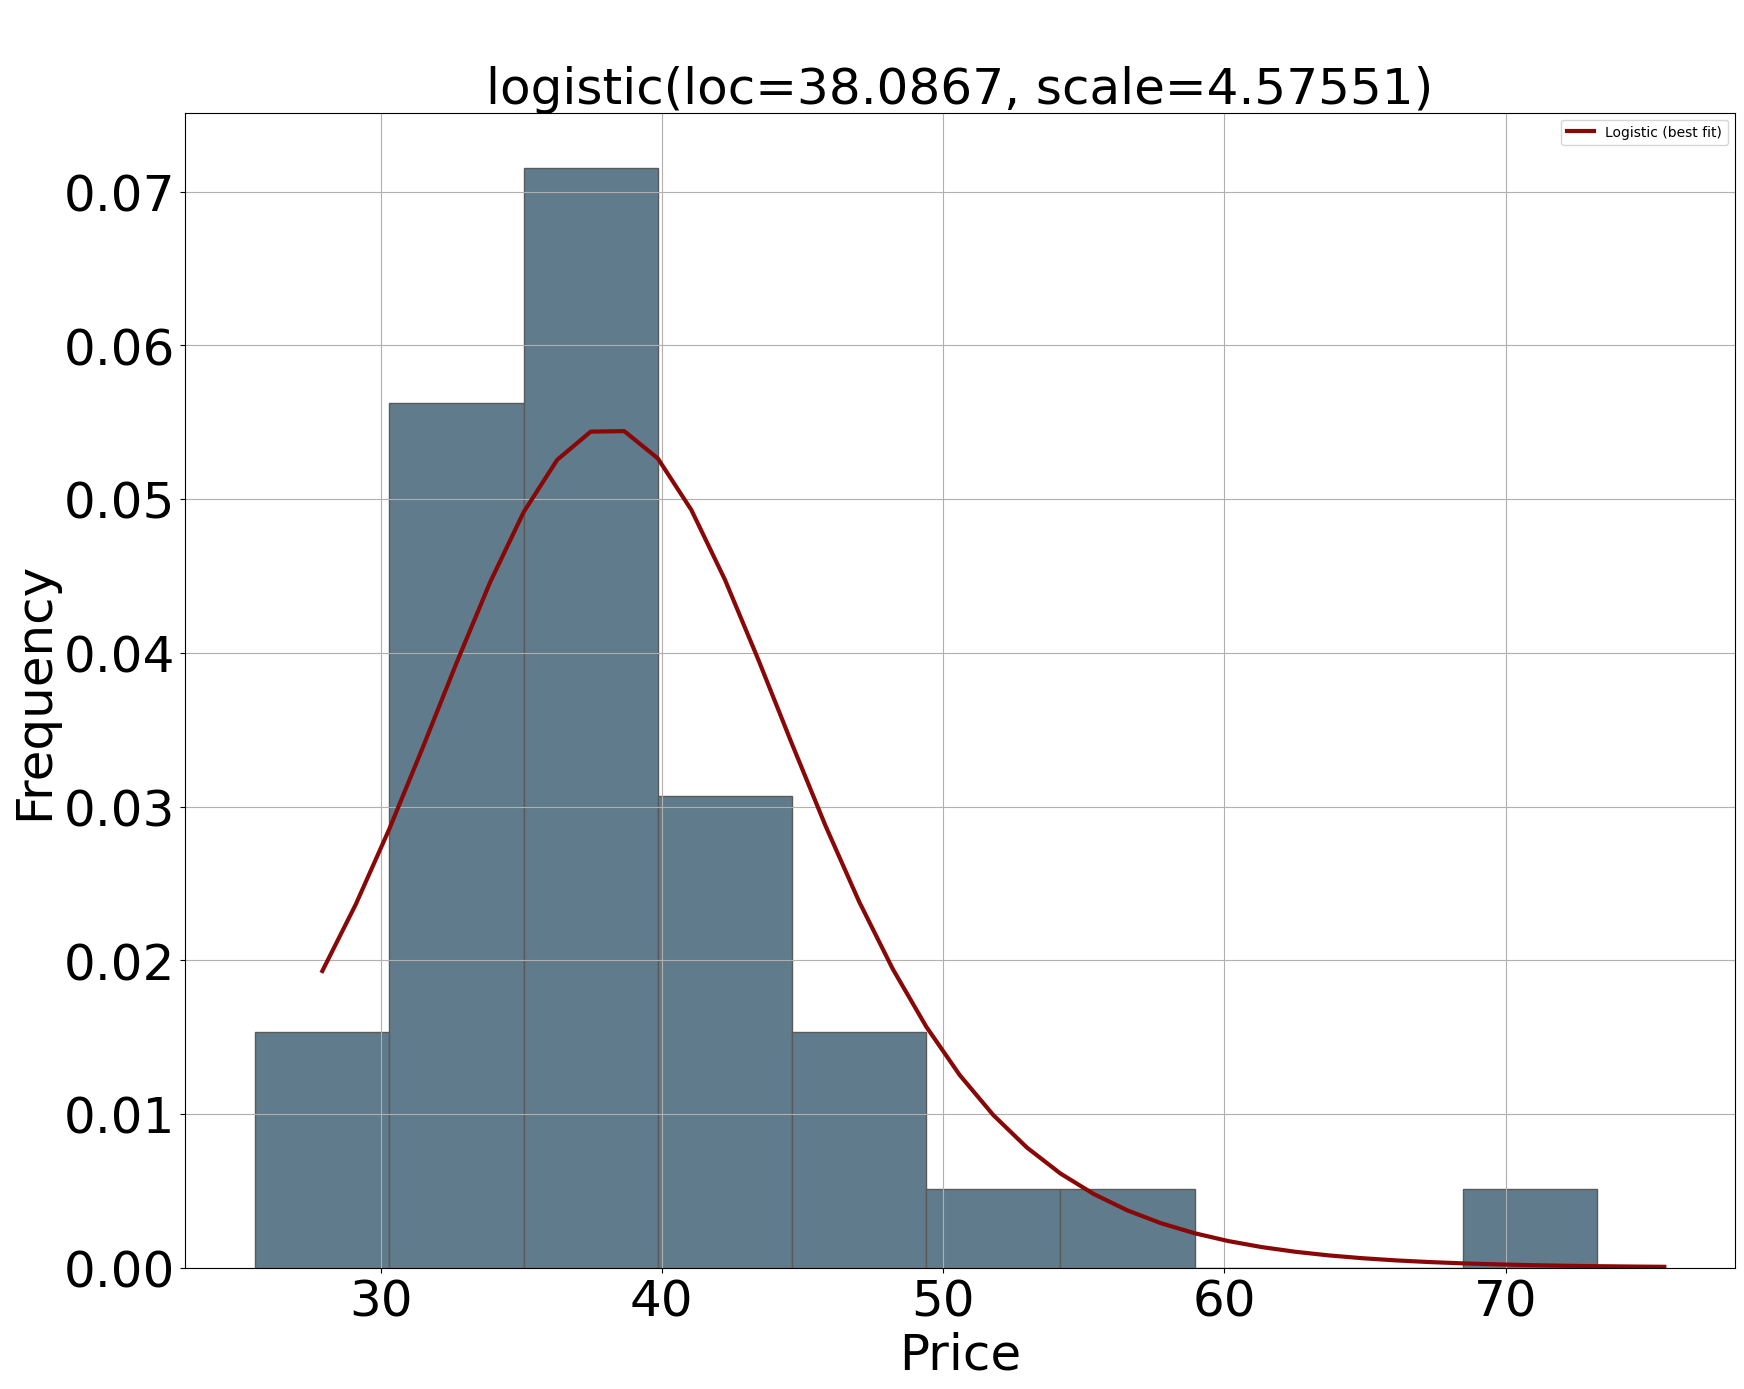

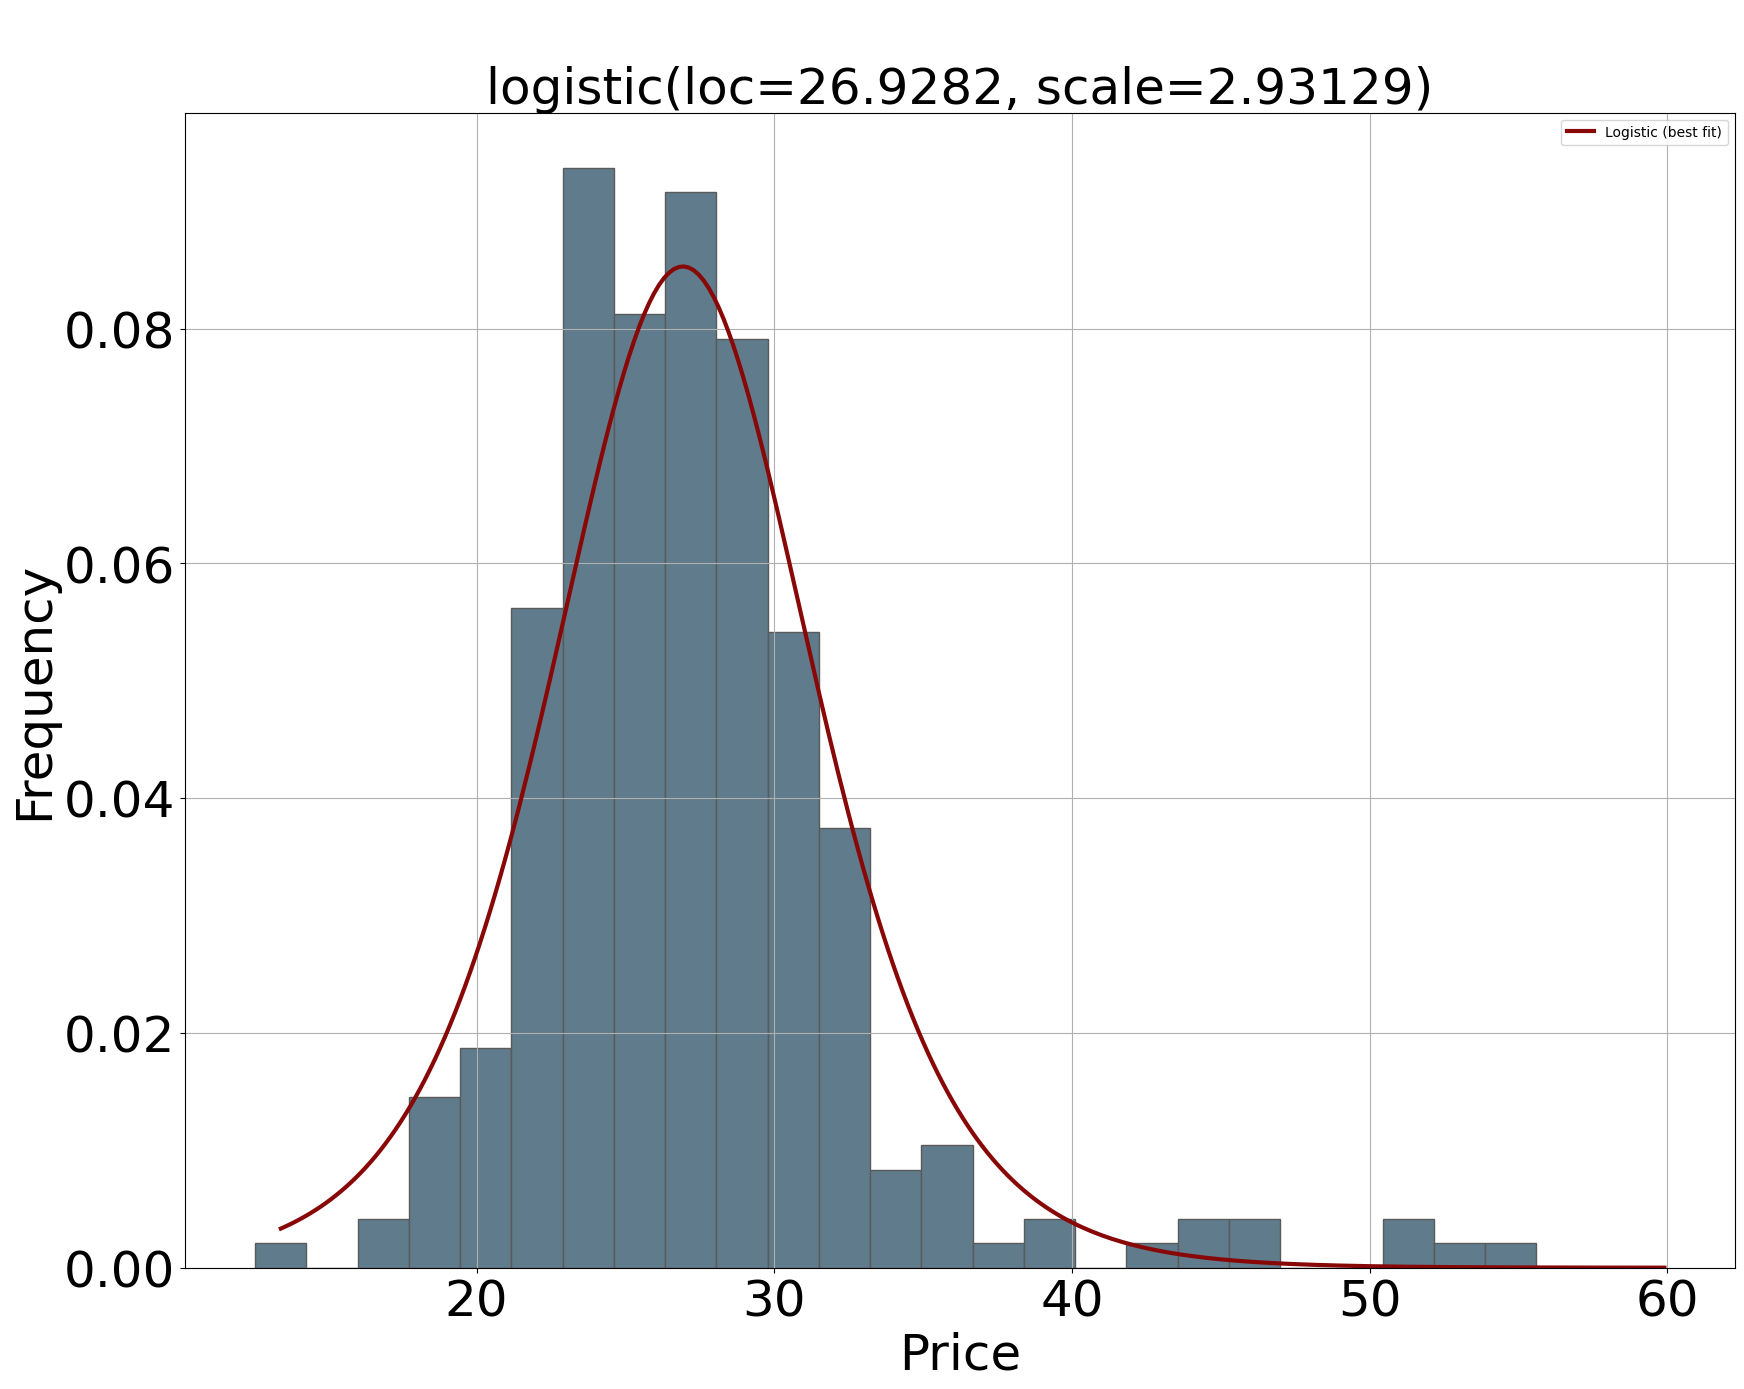

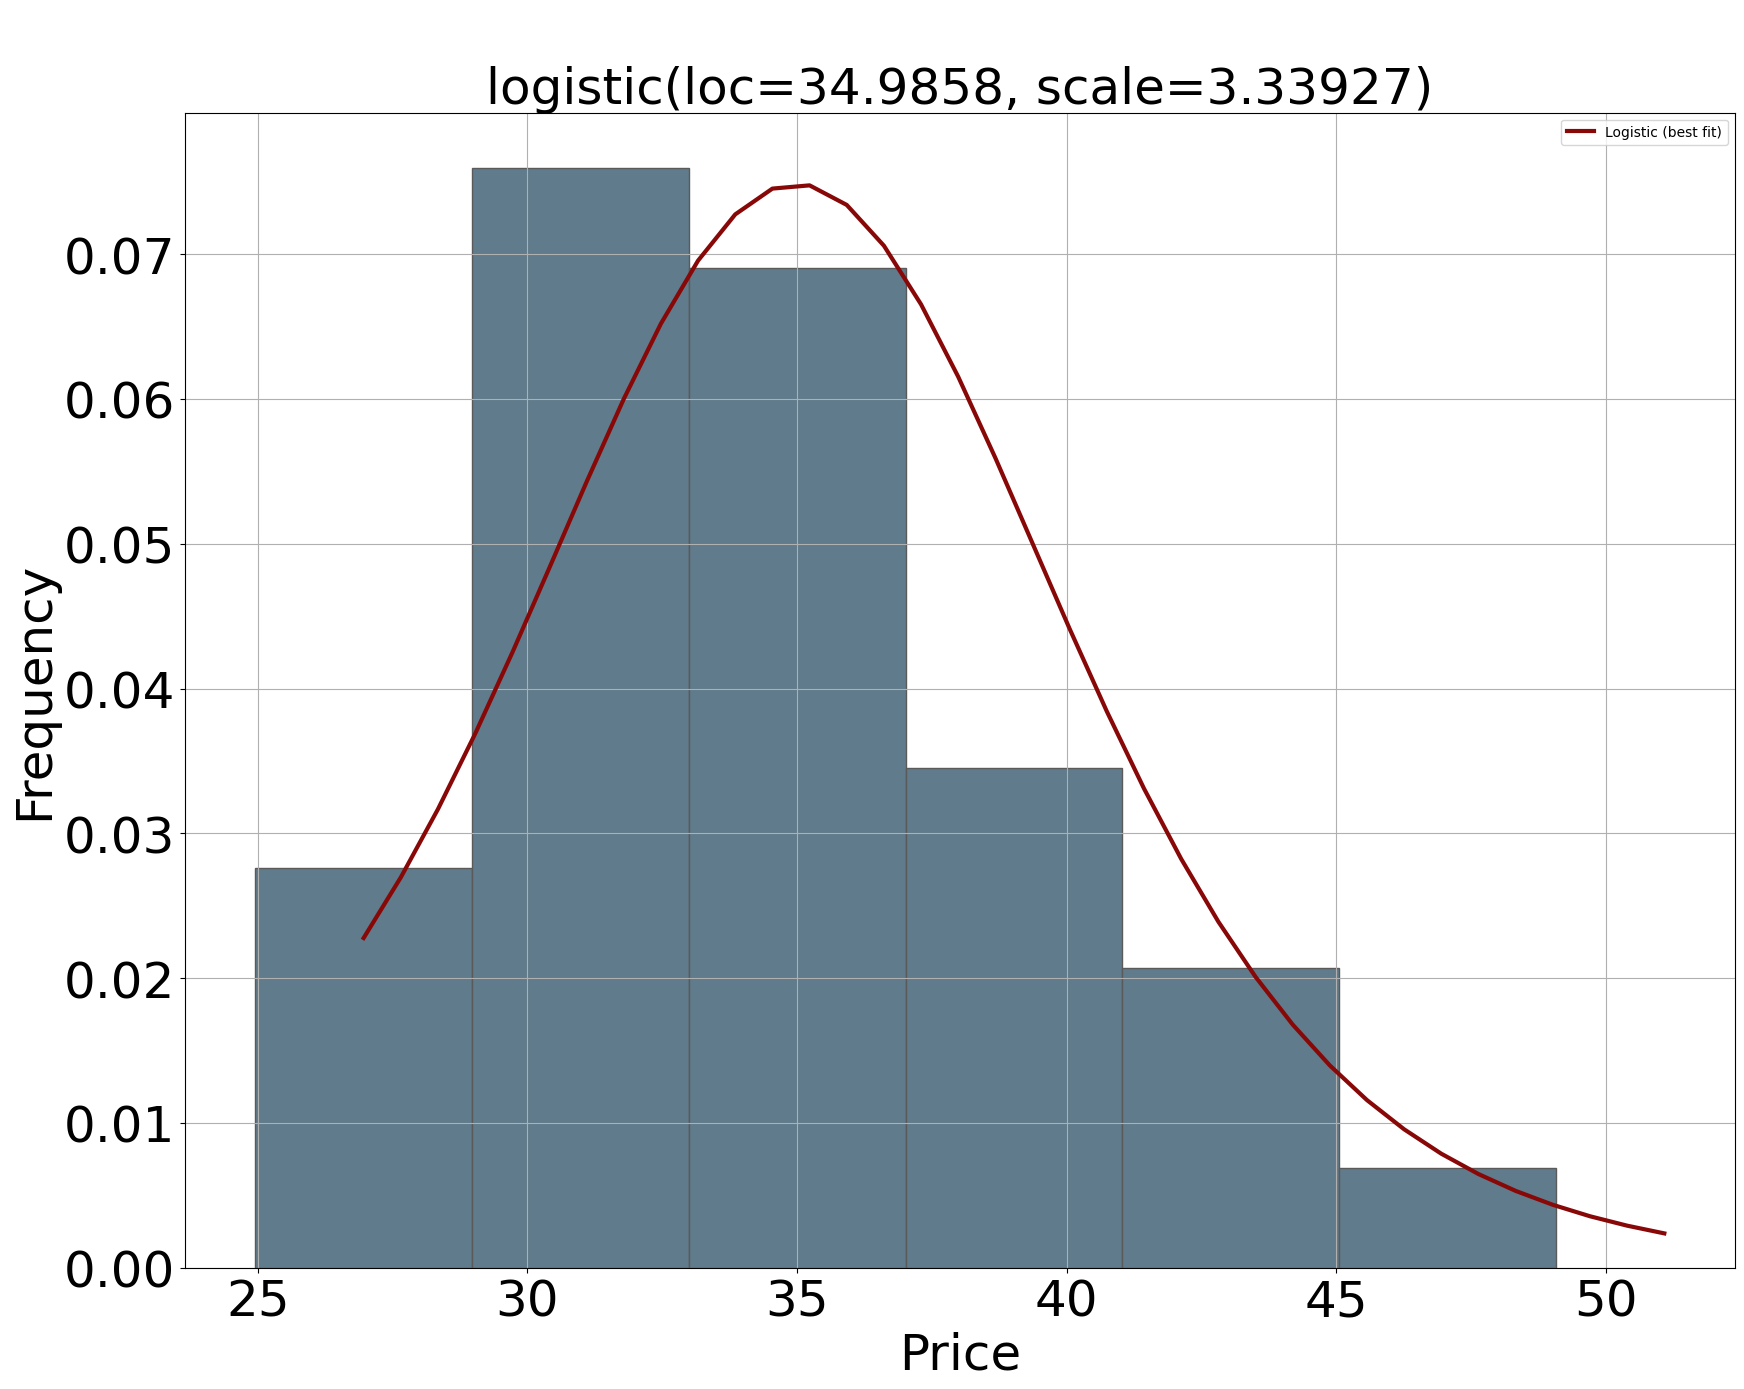

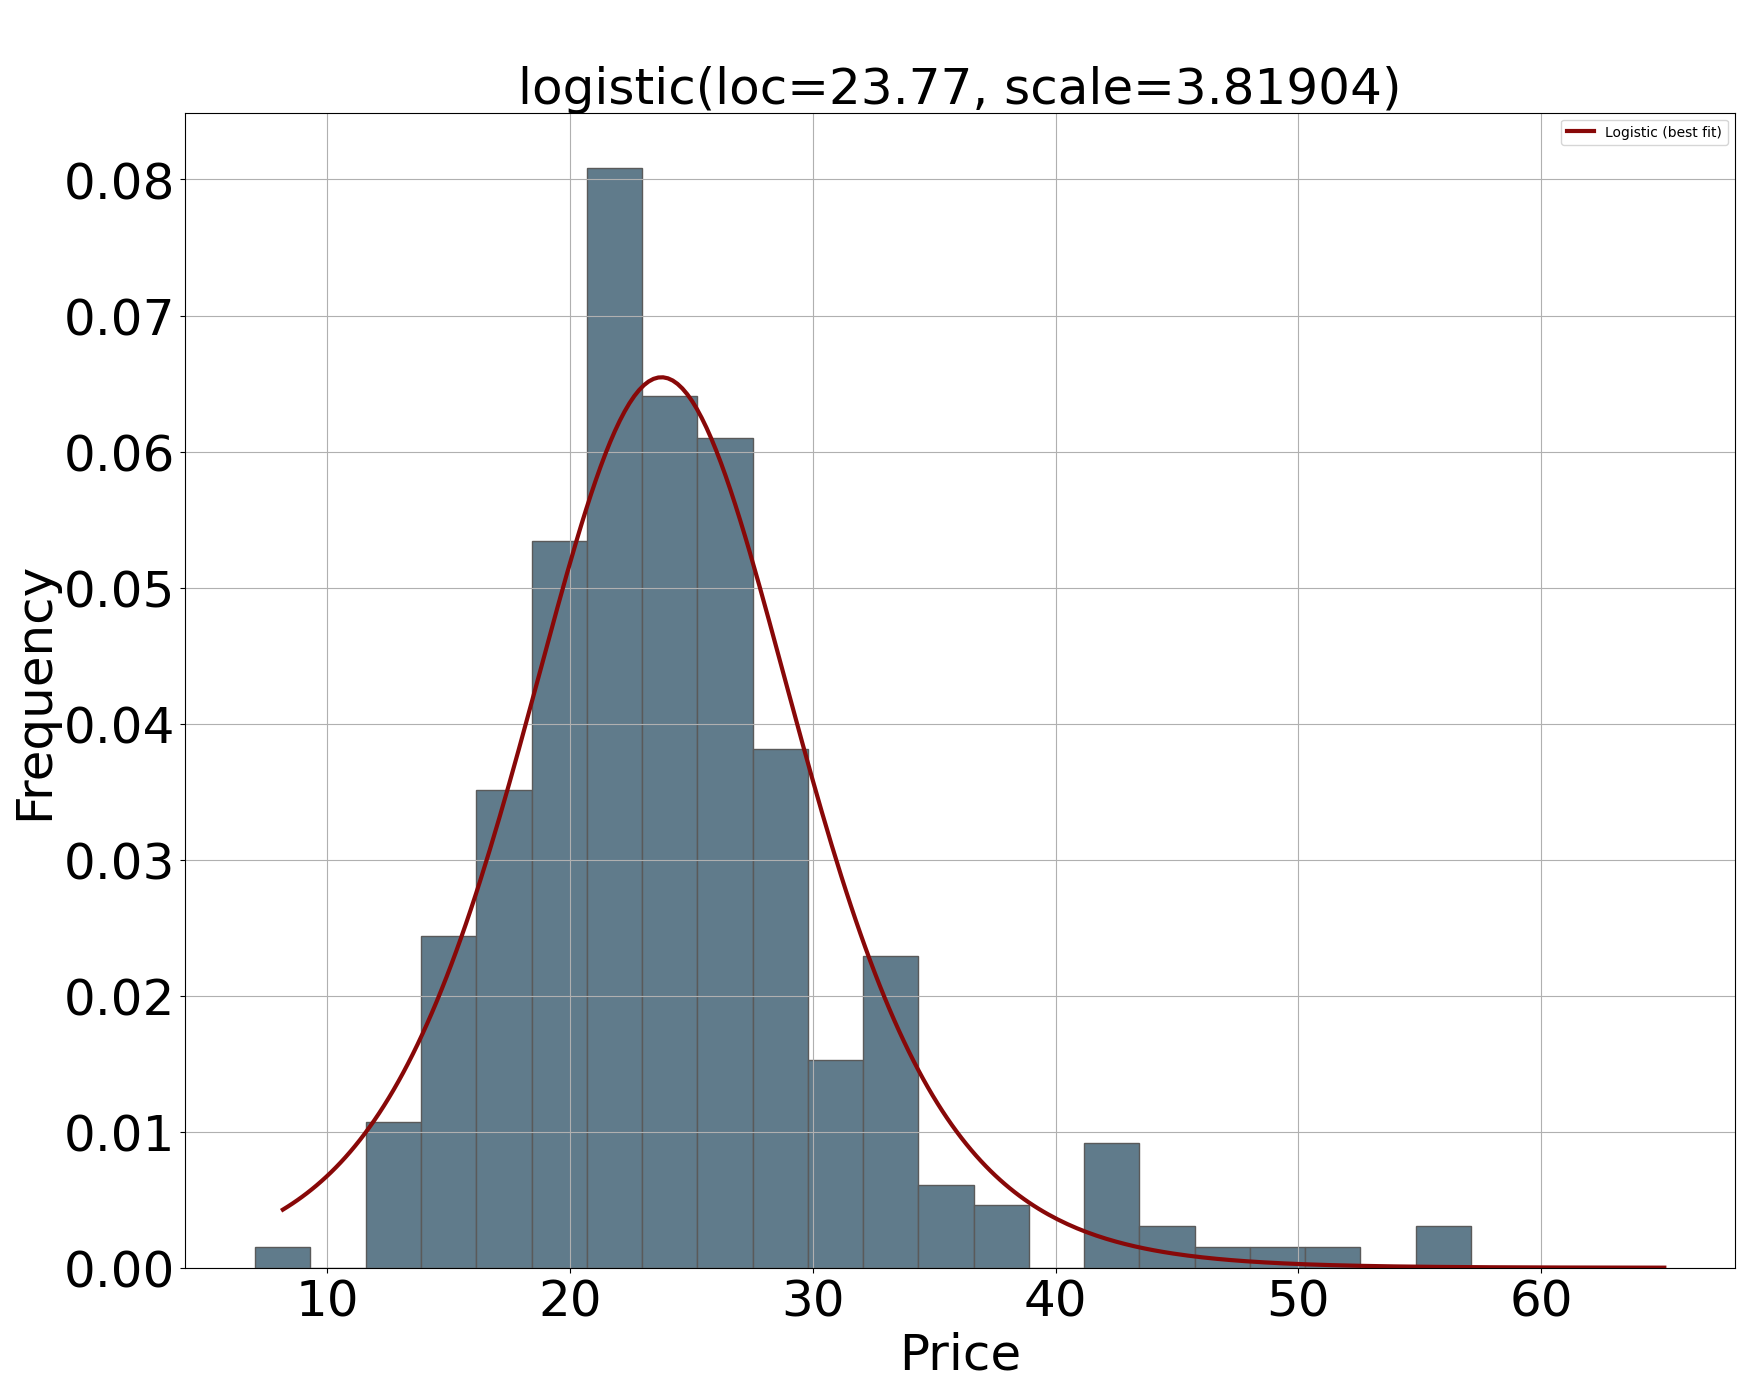

In [34]:
for (i,j) in [(2,8), (4,9), (7,1), (10,5)]:
    p_list = prices[i,j]
    dfit = distfit(distr='logistic')
    results = dfit.fit_transform(np.asarray(p_list))
    dfit.plot(chart='pdf',
                cii_properties=None,
                emp_properties=None,
                xlabel='Price',
                fontsize=36)

In [35]:
print(results['model']['score'])
print(results['model']['loc'])
print(results['model']['scale'])

0.000875437094638423
23.770006271109626
3.8190371501724254


In [36]:
import math
N = 10
rss_list = {}
b_df = pd.DataFrame(index=range(1, N+1), columns=range(1, N+1))
k_df = pd.DataFrame(index=range(1, N+1), columns=range(1, N+1))
for i in range(1,N+1):
    for j in range(1,N+1):
        if i == j:
            continue
        p_list = prices[i,j]
        if i == 2 and j == 7:
            p_list = prices[i,j][:-1]

        for model in ['logistic', 'expon', 'uniform', 'fisk']:
            dfit = distfit(distr=model)
            results = dfit.fit_transform(np.asarray(p_list))
            rss = results['model']['score']
            if model not in rss_list.keys():
                rss_list[model] = [rss] if not math.isnan(rss) else []
            else:
                rss_list[model] += [results['model']['score']] if not math.isnan(rss) else []

            if model == 'logistic':
                if math.isnan(rss):
                    print(i,j)
                scale = results['model']['scale']
                loc = results['model']['loc']
                b_df.loc[i, j] = 1/scale
                k_df.loc[i, j] = np.exp(loc/scale)

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [logistic] [0.00 sec] [RSS: 0.00202741] [loc=13.449 scale=2.618]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon] [0.00 sec] [RSS: 0.0189799] [loc=4.130 scale=9.669]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 0.0206919] [loc=4.130 scale=33.260]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [fisk] [0.03 sec] [RSS: 0.0014477] [loc=0.555 scale=12.512]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [logistic] [0.00 sec] [RSS: 0.000835635] [loc=19.101 scale=4.443]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon] [0.00 sec] [RSS: 0.00412116] [loc=4.400 scale=14.986]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 0.00592781] [loc=4.400 scale=60.890]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [fisk] [0.03 sec] [RSS: 0.000928118] [lo

In [40]:
for model in ['logistic', 'expon', 'uniform']:
    print(model, sum(rss_list[model])/len(rss_list[model]))

logistic 0.0015967466478524835
expon 0.012477541301676874
uniform 0.015182740325592671


In [41]:
print(k_df)

               1             2             3            4             5   \
1             NaN    170.104992     73.666179   459.115306    7363.20117   
2       76.314604           NaN    106.664962   167.390365  10747.860835   
3       47.240376    224.389252           NaN   467.467274    114.310749   
4     2268.292433    192.100831    501.141914          NaN   1732.062904   
5     1129.316076  12464.366807     96.785168   319.275446           NaN   
6     5577.762089   1326.006751     138.38091   112.027433    203.862658   
7    35492.378845   1981.907325   2561.946865   194.170413   1677.578236   
8    55329.228338  27325.733304   1370.643809  1214.141032    187.660091   
9   189009.206869   2084.111029  28897.054877  3884.235344   1669.846131   
10  277086.582431  349864.84011  10409.976155   735.494264    504.760239   

             6             7             8             9              10  
1   7817.324668  21928.158969  10886.497195   8463.360962     210.013524  
2    997.0246

In [42]:
print(b_df)

          1         2         3         4         5         6         7   \
1        NaN  0.381911  0.225095  0.239669  0.323971  0.272504  0.276793   
2   0.299228       NaN  0.275838  0.321732   0.31766    0.2244  0.274326   
3   0.217765  0.325507       NaN  0.381421  0.280899  0.233446  0.243868   
4    0.28077  0.341464  0.374311       NaN  0.296359  0.232503  0.317538   
5   0.228685  0.316145  0.269526  0.232144       NaN  0.351897  0.355586   
6   0.255161  0.260925  0.251653   0.25744  0.323806       NaN  0.360608   
7   0.299467  0.298877  0.319809  0.311636  0.362985  0.339042       NaN   
8   0.281704  0.288233   0.24358  0.223084  0.268309   0.22215  0.303395   
9   0.280716  0.235653  0.308959  0.313873  0.285352  0.232036  0.388688   
10  0.308035  0.356964  0.270023  0.184539  0.261846  0.210862  0.284624   

          8         9         10  
1    0.24482  0.217765  0.124182  
2   0.218555    0.2806  0.346306  
3    0.20959  0.286869  0.236916  
4   0.237574  0.341147 

In [43]:
data = {'market_size': total_trips, 'b': b_df, 'k': k_df, 'avg_dist': avg_dist, 'avg_time': avg_time, 'uber': uber, 'avg_price': avg_price}

In [45]:
import pickle
with open('logistic_18_20_030323.pkl', 'wb') as f:
    pickle.dump(data, f)